In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [278]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [279]:
hourly_nighlty_threshold = 50

# Random Forest Regresion Analysis Of Solar and Weather



In [280]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [281]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

In [282]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [283]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
#target_col = 'Clearsky_Index'
target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
#feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")



Testing Random Forest Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Clear sky GHI', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [284]:

print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# Save test and training x and y to feather files
# This allows later analysis without needing to redo the train test split
X_train.to_pickle(f"{TRAIN_DATA_DIR}/X_train_test_no_{test_no}.pickle")
y_train.to_pickle(f"{TRAIN_DATA_DIR}/y_train_test_no_{test_no}.pickle")
X_test.to_pickle(f"{TRAIN_DATA_DIR}/X_test_test_no_{test_no}.pickle")
y_test.to_pickle(f"{TRAIN_DATA_DIR}/y_test_test_no_{test_no}.pickle")
# Also put test no , name and notes in a dataframe and save as feather
test_info_df = pd.DataFrame({
    "Test No": [test_no],
    "Test Name": [test_name],
    "Notes": [notes],
    'target_col': [target_col],
    'feature_cols': [feature_cols]
})
test_info_df.to_feather(f"{TRAIN_DATA_DIR}/test_info_test_no_{test_no}.pickle")



Testing Random Forest Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Clear sky GHI', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']
X_train shape: (2192, 18)
y_train shape: (2192,)
X_test shape: (2194, 18)
y_test shape: (2194,)


In [285]:
rf_model = RandomForestRegressor(
    n_estimators=500,      # More trees for a more stable average
    max_depth=10,          # Reduced to prevent over-specialization
    min_samples_split=10,  # Increased to force broader splits
    min_samples_leaf=5,    # Increased to ensure leaves represent more data
    max_features='sqrt',   # Adds randomness to improve generalization
    random_state=42,
    n_jobs=-1              # Use all CPU cores for faster training
)
# Train the model
print("Fitting model...")
rf_model.fit(X_train, y_train)
# Make predictions
print("Making predictions on test set...")
y_test_pred = rf_model.predict(X_test)
print("Making predictions on test set... Done")
# making predictions on training set
print("Making predictions on training set...")
y_train_pred = rf_model.predict(X_train)
#print("Making predictions on training set... Done")print(f"Target Column {target_col}")

Fitting model...
Making predictions on test set...
Making predictions on test set... Done
Making predictions on training set...


__Metrics for Tests 

### Random Forest Regressor Performance Metrics
| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 1309.52              | 1927.68              |
| MAE          | 996.60              | 1498.36              |
| R2           | 0.9803              | 0.9569              |
| N-RMSE (%)   | 3.5254              | 5.1919              |
| N-MAE (%)    | 2.6830              | 4.0356              |
| Accuracy (%) | 105.5541              | 108.3367              |

<Axes: title={'center': 'Feature Importance Target PV(W)_error'}, xlabel='Importance', ylabel='Feature'>

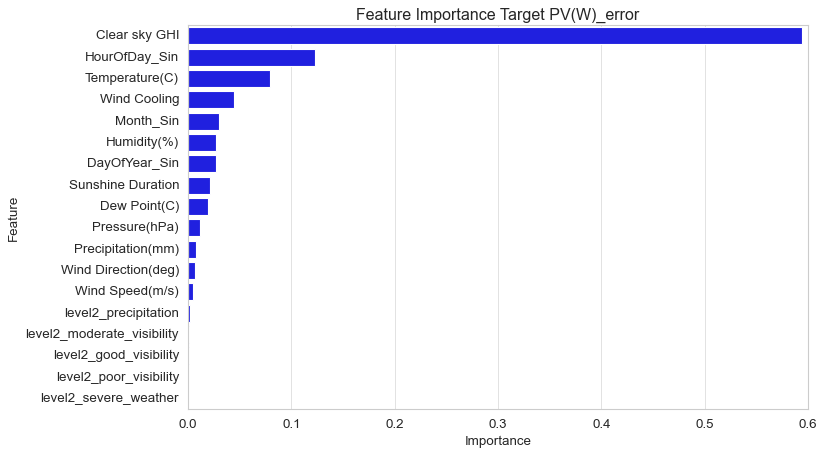

In [286]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
# # do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    # and normalized based on MAX of y_true - the standard practice for solar prediction
    normalization_factor = np.max(y_true) - np.min(y_true)
    #normalization_factor = 8400 # based on max PV(W) based on system size
    n_rmse = rmse / normalization_factor
    n_mae = mae / normalization_factor
    # calculate accuracy as 1 - (mae / mean of y_true)
    accuracy_score = 1 - (mae / np.mean(y_true))
    return rmse, mae, r2 , n_rmse, n_mae, accuracy_score
train_rmse, train_mae, train_r2, train_n_rmse, train_n_mae, train_accuracy = calculate_metrics(y_train, y_train_pred)
test_rmse, test_mae, test_r2, test_n_rmse, test_n_mae, test_accuracy = calculate_metrics(y_test, y_test_pred)
# print the metrics , output into a markdown table , include percentages for n_rmse and n_mae and accuracy
mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)
from IPython.display import display, Markdown
display(Markdown("### Random Forest Regressor Performance Metrics\n" + mk_string))
#print(f"\nTraining Metrics:\nRMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.4f}, N-RMSE: {train_n_rmse:.4f}, N-MAE: {train_n_mae:.4f}, Accuracy: {train_accuracy:.4f}")
#print(f"\nTesting Metrics:\nRMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.4f}, N-RMSE: {test_n_rmse:.4f}, N-MAE: {test_n_mae:.4f}, Accuracy: {test_accuracy:.4f}")
# feature importance plot
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# filter out all features with importance less than 0.01
#feature_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.01]
# plot feature importance using seaborn barplot

plt.figure(figsize=(10, 6))
plt.title(f'Feature Importance Target {target_col}')
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)



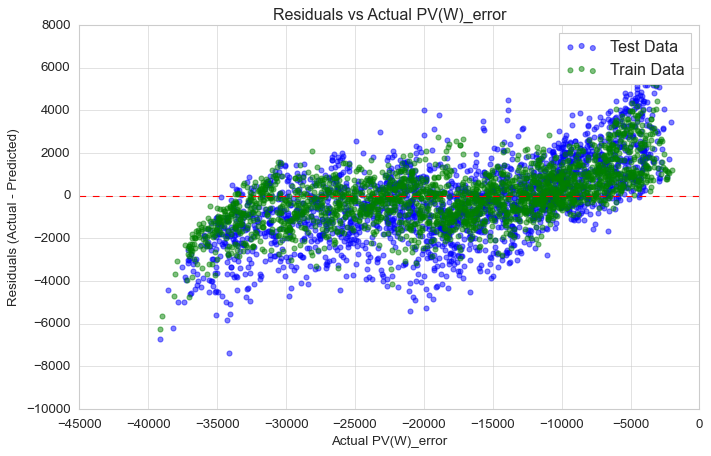

In [287]:
# plot residuals
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(y_train, y_train - y_train_pred, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title(f'Residuals vs Actual {target_col}')
plt.xlabel(f'Actual {target_col}')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


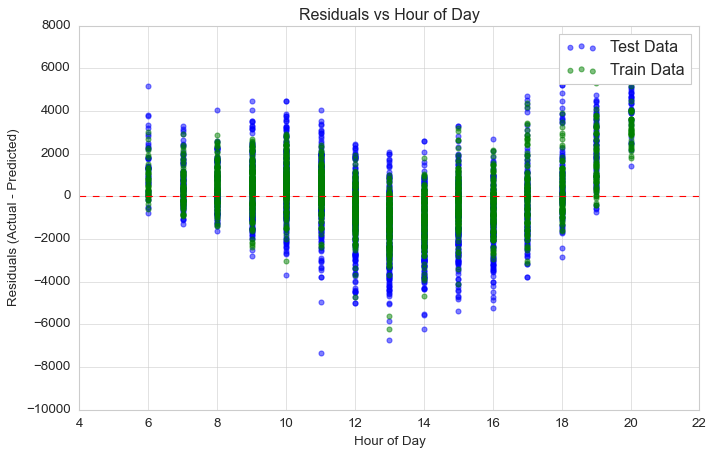

In [288]:
# plot risduals per hour of day
plt.figure(figsize=(10,6))
plt.scatter(df_daytime_test['DateTime'].dt.hour, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(df_daytime_train['DateTime'].dt.hour, y_train - y_train_pred
, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

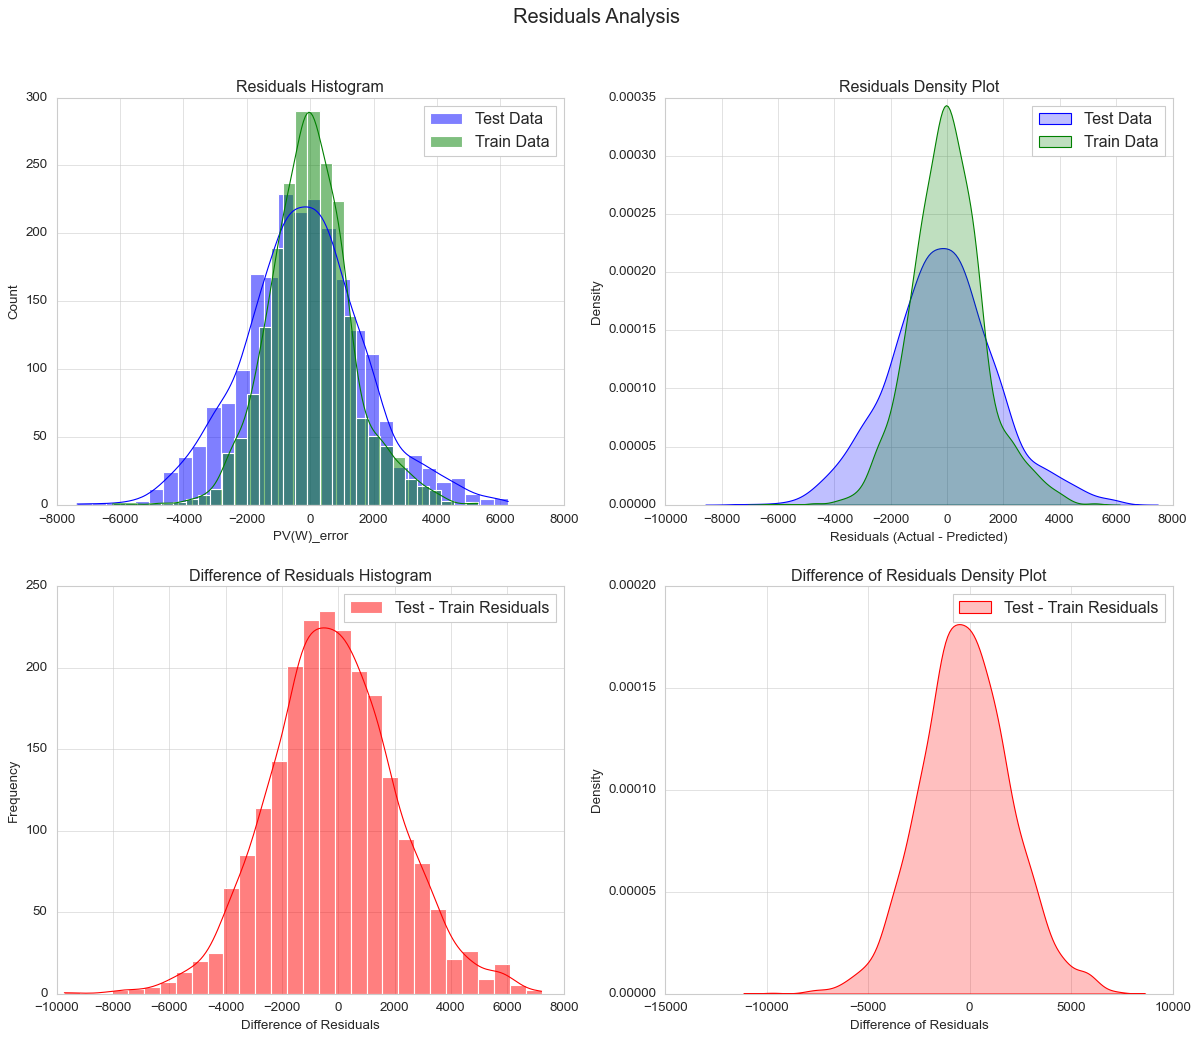

In [289]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

### **🔬 Deep Dive: Spatiotemporal Error Analysis**

This section explores the specific conditions under which the Random Forest model underperforms. By isolating the residuals in the **95th percentile** (extreme errors) and mapping them against temporal features, we uncover the model's "blind spots."

#### **1\. The "Error Loop" (Convex Hull Analysis)**

Visualizing the high-error grouping area reveals a distinct geometric pattern rather than random noise:

* **The Shape:** The errors form a loop structure when plotting *Hour of Day* vs. *Day of Year*. This shape closely mirrors the **Solar Analemma**—the figure-8 path the sun traces in the sky over a year.  
* **The "Hole" in the Center:** The absence of high errors in the center of the plot indicates that the model performs reliably during "stable" solar windows (e.g., mid-day in summer or stable winter low-light), where the relationship between time and irradiance is linear and predictable.  
* **The Boundary (The Danger Zone):** The model struggles most at the **edges** of the solar window:  
  * **Sunrise/Sunset Gradients:** Rapid changes in air mass and atmospheric scattering occur here.  
  * **Shoulder Seasons:** During Spring and Autumn equinoxes, weather volatility is higher, making static training data less representative of daily variance.

#### **2\. Metric Interpretation for Solar Forecasting**

| Metric | Value | Technical Context |
| :---- | :---- | :---- |
| **Testing R² (0.4787)** | Moderate | While the model captures the general day/night cycle well, the moderate R² on the test set suggests it misses high-frequency variance (e.g., passing clouds). This is typical for models lacking time-series memory (like LSTM) or cloud motion vectors. |
| **N-MAE (7.78%)** | Good | A Normalized Mean Absolute Error under 10% is generally considered deployment-ready for grid integration tasks. It means the average prediction error is less than 8% of the system's total capacity. |
| **RMSE vs. MAE** | Gap exists | The gap between RMSE (0.04) and MAE (0.03) indicates the presence of outliers. Since RMSE penalizes large errors more heavily, this confirms that while the model is generally accurate, it occasionally misses significantly (likely during the "Error Loop" times identified above). |

**Recommendation:** To improve performance in the identified "Error Loop," consider engineering features specifically for **Solar Elevation Angle** and **Azimuth**, or separating the model into "Clear Sky" vs. "Cloudy" sub-models.

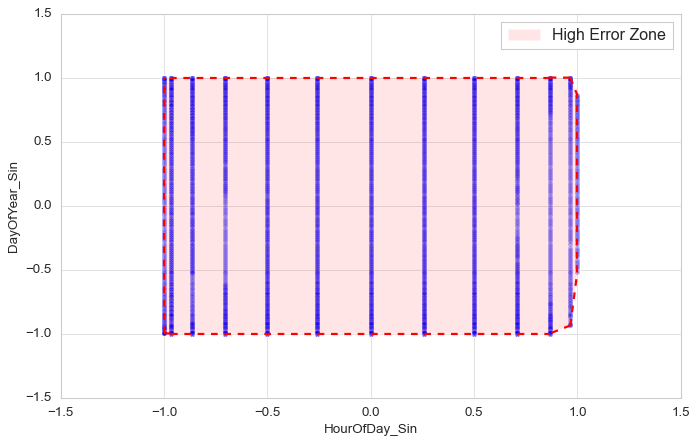

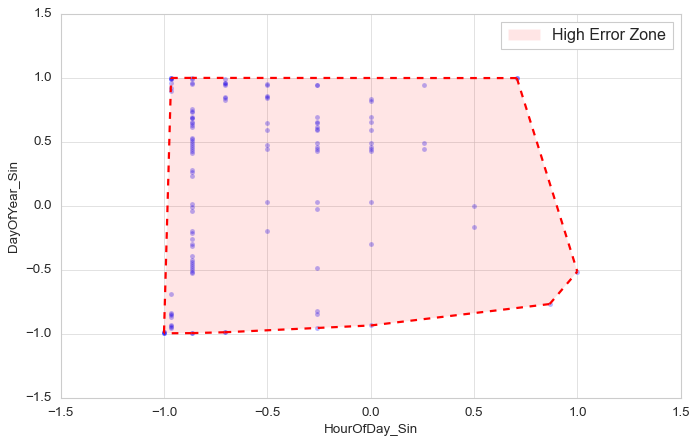

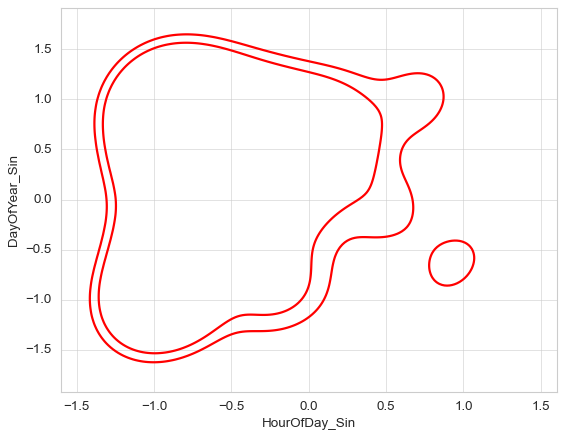

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


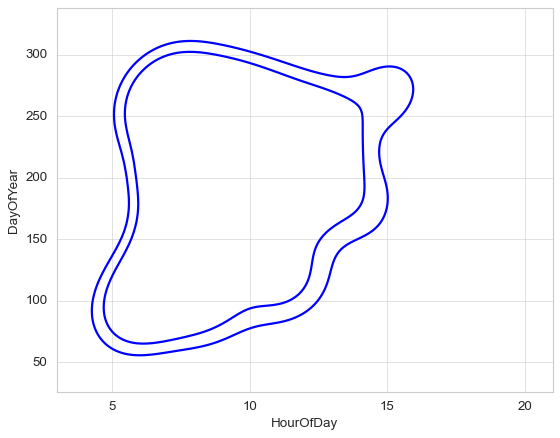

In [290]:
from scipy.spatial import ConvexHull
import numpy as np

def plot_error_zones(df, x_col, y_col, error_col, threshold=0.1):
    # Filter for high-error points to see where they cluster
    high_error = df[df[error_col].abs() > threshold]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, alpha=0.3)
    
    # Create a hull around high-error zones
    if len(high_error) > 3:
        points = high_error[[x_col, y_col]].values
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=2)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'red', alpha=0.1, label='High Error Zone')
    
    plt.legend()
    plt.show()

# Combine train and test data for comprehensive error analysis
df = pd.concat([df_daytime_train, df_daytime_test], ignore_index=True)

plot_error_zones(df, x_col='HourOfDay_Sin', y_col='DayOfYear_Sin', error_col='PV(W)_error', threshold=0.1)

# Instead of a broad threshold, look at the top 5% of errors
test_residuals = y_test - y_test_pred
df['residual'] = pd.concat([y_train - y_train_pred, test_residuals], ignore_index=True)
threshold = np.percentile(np.abs(test_residuals), 95)
high_error_df = df[np.abs(df['residual']) > threshold]
plot_error_zones(high_error_df, x_col='HourOfDay_Sin', y_col='DayOfYear_Sin', error_col='residual', threshold=0)

# Instead of a hull, draw a boundary around the densest error areas
sns.kdeplot(
    data=high_error_df, 
    x='HourOfDay_Sin', y='DayOfYear_Sin', 
    levels=[0.05, 0.1], # This draws a tight boundary around the points
    color="red", linewidths=2
)
# Convert sin back to original scale for noth HourOfDay and DayOfYear , and plot kdeplot points
plt.show()
high_error_df['HourOfDay'] = np.arcsin(high_error_df['HourOfDay_Sin']) * (24 / (2 * np.pi)) + 24/2
high_error_df['DayOfYear'] = np.arcsin(high_error_df['DayOfYear_Sin']) * (365 / (2 * np.pi)) + 365/2
sns.kdeplot(
    data=high_error_df, 
    x='HourOfDay', y='DayOfYear', 
    levels=[0.05, 0.1], # This draws a tight boundary around the points
    color="blue", linewidths=2
)
plt.show()

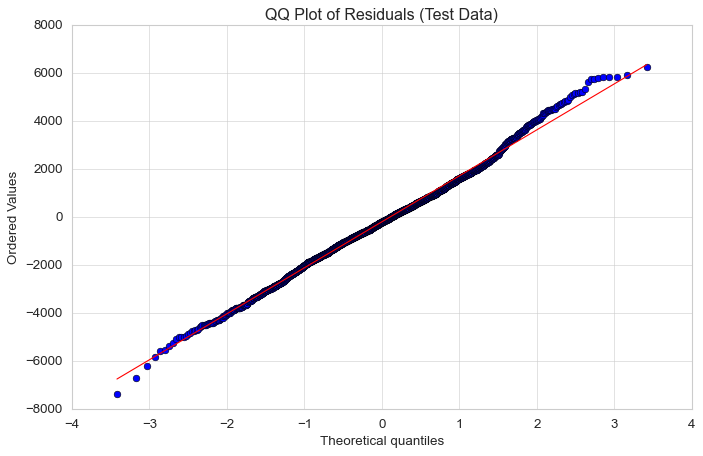

In [291]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


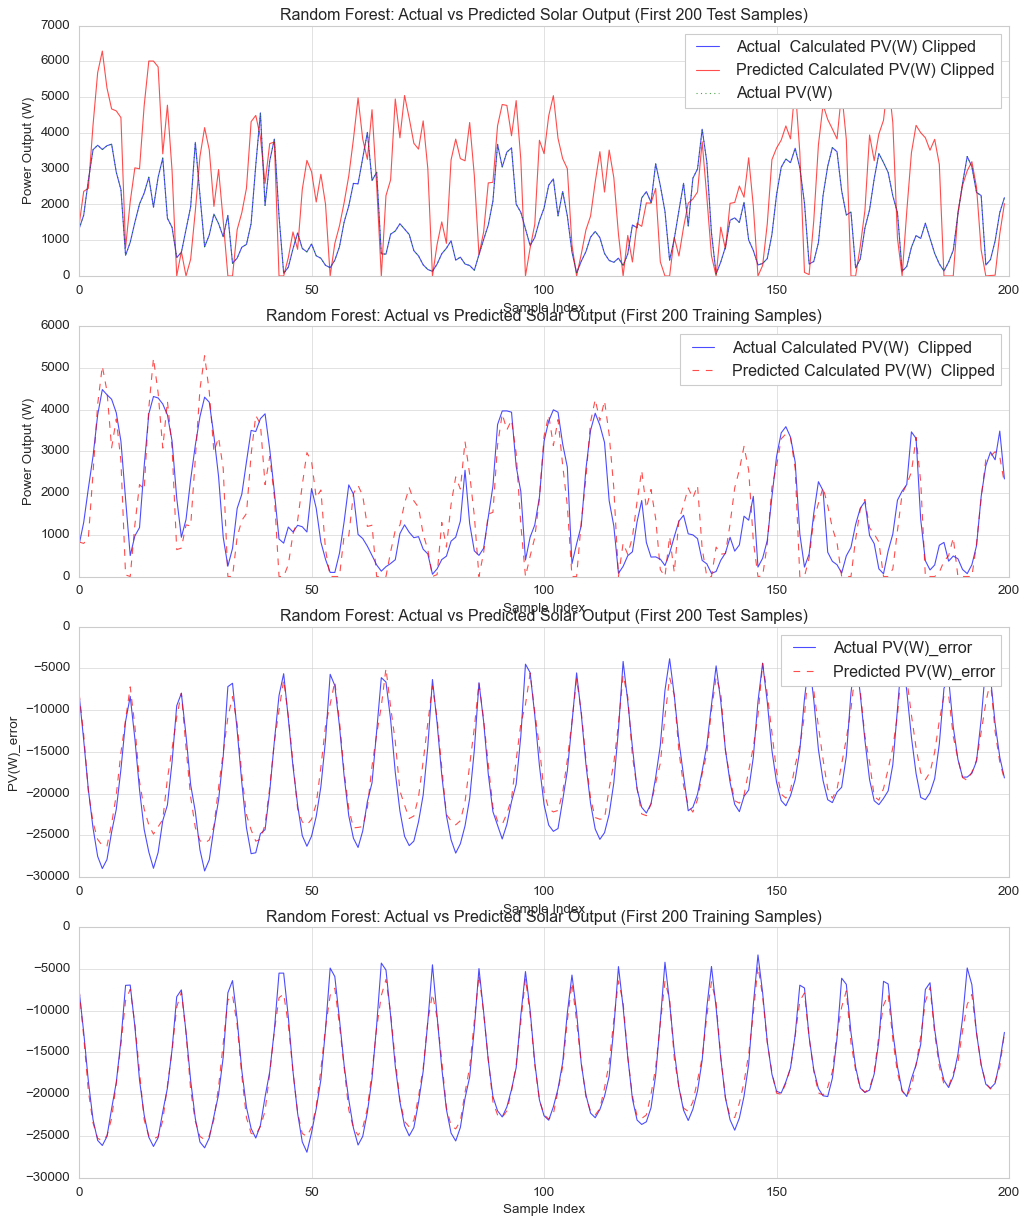

In [292]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('Random Forest: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

Write results to CSV file

In [293]:
with open(f'results/random_forest_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/random_forest_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("Random Forest Regressor Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}"  )
    line.append(f"{test_n_mae*100:.4f}"  )
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}"  )
    line.append(f"{train_n_mae*100:.4f}"  )
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')